In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib

data_dir = pathlib.Path('./data/')

In [4]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1212


In [5]:
batch_size = 32
img_height = 512
img_width = 512

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 1212 files belonging to 3 classes.
Using 970 files for training.
Found 1212 files belonging to 3 classes.
Using 242 files for validation.
['Astrocytoma', 'Glioblastoma', 'Oligodendroglioma']


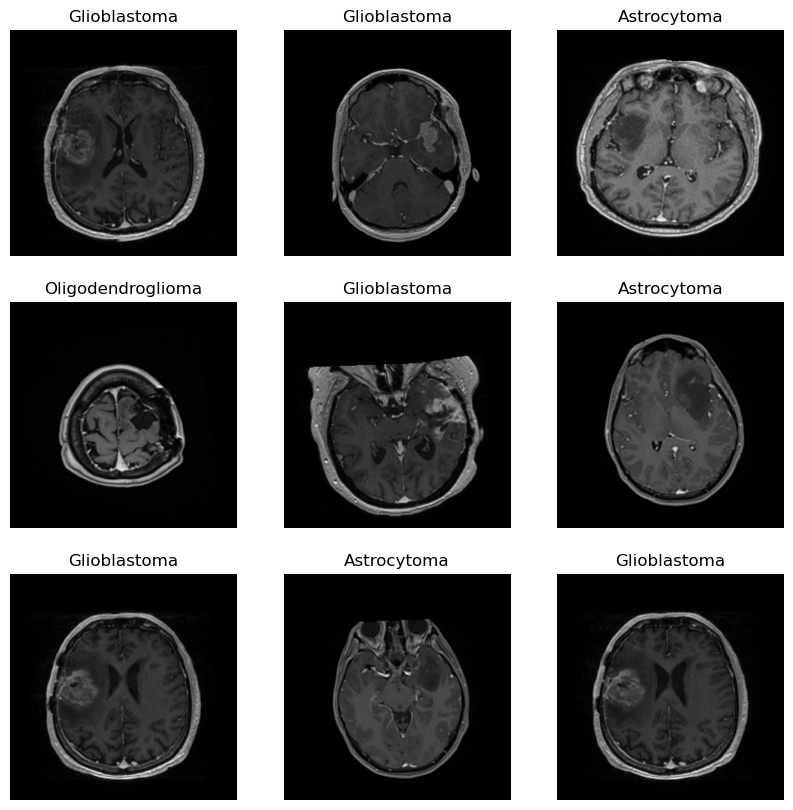

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Model Training

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#normalization_layer = layers.Rescaling(1./255)
#train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(None, img_height, img_width, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 512, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                 

In [9]:
import os

epochs = 35

# dont train if model already exists

model_was_trained = False

if os.path.exists('model.h5'):
  model = keras.models.load_model('model.h5')
  print('Model already exists')
else:
  model_was_trained = True

  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )



Model already exists


In [10]:
# store model
model.save('model.h5')

/Users/sebastiansalletmayer/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Results

In [11]:
if model_was_trained:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Confusion Matrix

In [12]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

8/8 [==============================] - 3s 304ms/step


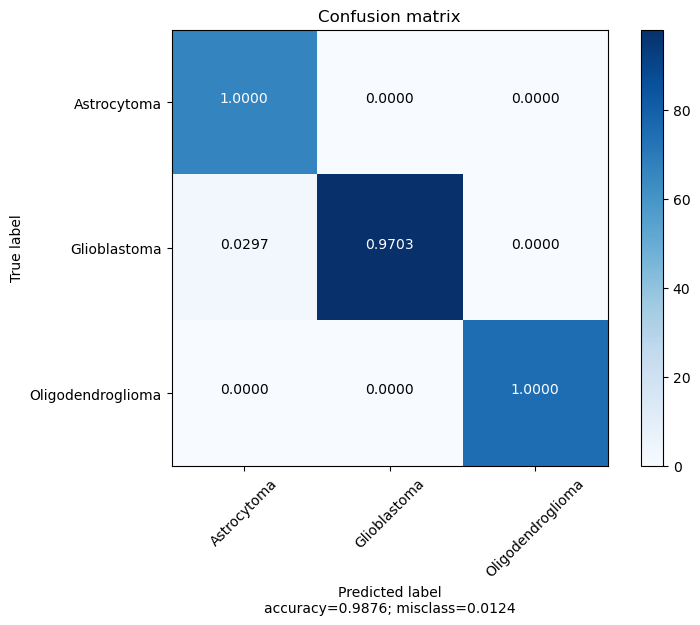

In [13]:
## Create multiclass confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

predictions = model.predict(val_ds)
y_pred = np.argmax(predictions, axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, target_names=class_names, normalize=True)

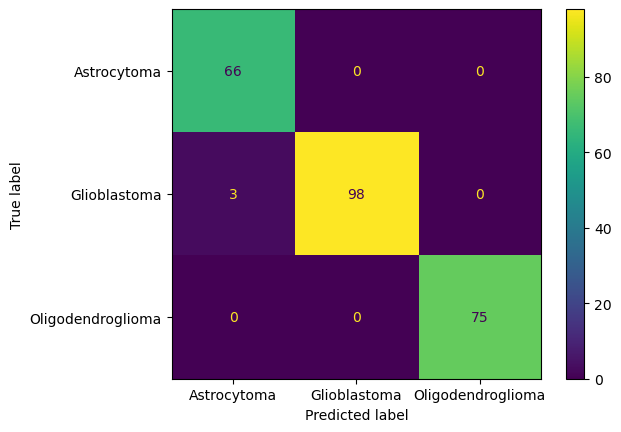

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()


In [15]:
# use one image in validation set and predict to test
for image_batch, labels_batch in val_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

img = image_batch[0]
print(img.shape)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

(32, 512, 512, 3)
(32,)
(512, 512, 3)
1/1 [==============================] - 0s 67ms/step
This image most likely belongs to Glioblastoma with a 99.99 percent confidence.


In [16]:
import innvestigate
tf.compat.v1.disable_eager_execution()

analyzer = innvestigate.create_analyzer("deep_taylor", model)

In [ ]:
import sys
sys.setrecursionlimit(900000)

analyzer.analyze(img)

: 

In [ ]:
a = analyzer.analyze(image_batch[:2])

a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))

RuntimeError: Attempting to capture an EagerTensor without building a function.